### Dinámica Secular del sistema

# Descripción

Este notebook carga los archivos de salida generados por `ncorp13` (por ejemplo `ncorp13.dat`, `planet1.dat`, `planet2.dat`, ...) y grafica la evolución temporal de los elementos orbitales: a, e, inc, M, w, O y la longitud del pericentro ϖ = w + O.

Cada elemento se grafica en su propia celda para facilitar la ejecución y la exportación de figuras.

P_outer = 1050.11000 d = 2.875044 yr (σ=0.000356 yr)
Periodo estimado planet2 (interno) = 1.014917 yr
T_total = 100 * P_outer = 287.504449 yr
dt_salida = P_inner/100 = 0.010149171 yr
muestreo mediano planet1 = 1.130000e-04 yr, planet2 = 1.130000e-04 yr


/tmp/ipykernel_101056/3826445534.py:163: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


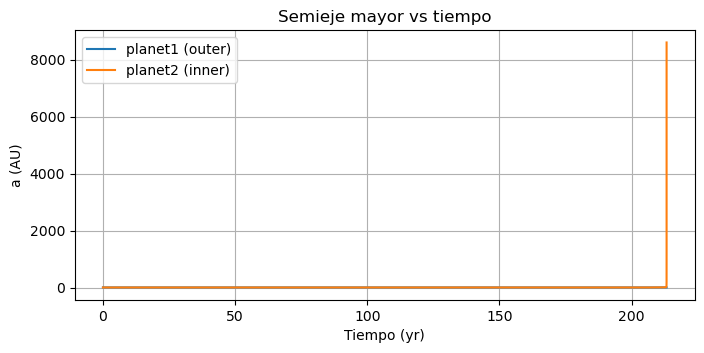

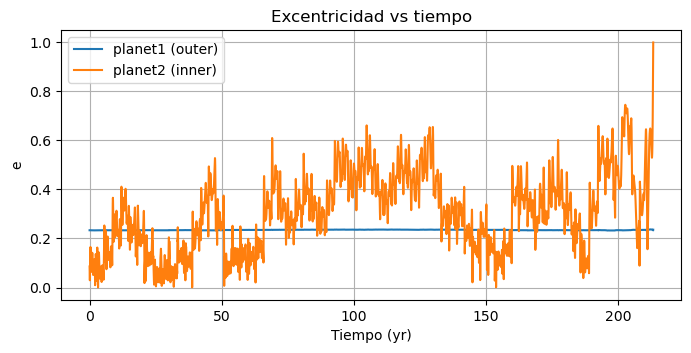

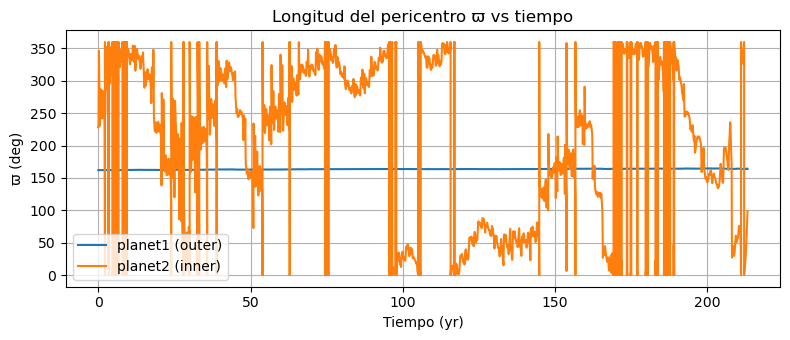

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# --- CONFIGURACIÓN ---
# Periodo reportado (días) del cuerpo más externo (Nu Oct B = planet1)
P_outer_days = 1050.11
P_outer_sigma_days = 0.13

# convertir a años (1 año = 365.25 d)
days_per_year = 365.25
P_outer_yrs = P_outer_days / days_per_year
P_outer_sigma_yrs = P_outer_sigma_days / days_per_year

outer_planet = 1   # Nu Oct B (más externo)
inner_planet = 2   # Nu Oct Ab (más interno)

print(f"P_outer = {P_outer_days:.5f} d = {P_outer_yrs:.6f} yr (σ={P_outer_sigma_yrs:.6f} yr)")

# --- FUNCIONES DE CARGA ROBUSTA ---
def read_numeric_lines(fname):
    rows = []
    with open(fname, 'r') as f:
        for L in f:
            s = L.strip()
            if not s or s.startswith('#'):
                continue
            parts = s.split()
            try:
                floats = [float(x) for x in parts]
            except ValueError:
                continue
            rows.append(floats)
    if not rows:
        raise ValueError(f"{fname} no contiene líneas numéricas legibles.")
    return np.array(rows, dtype=float)

def load_planet(n):
    """
    Carga planet{n}.dat. Soporta ambos formatos:
      - individual files (no columna id): t, a, e, inc, M, w, Om, ...
      - combined files (con id): t, id, a, e, inc, M, w, Om, ...
    Devuelve t (asumido en AÑOS), a, e, w, Om, varpi (deg).
    """
    fname = Path(f"planet{n}.dat")
    if not fname.exists():
        raise FileNotFoundError(f"{fname} no encontrado.")
    data = read_numeric_lines(fname)
    ncol = data.shape[1]
    # Detectar si hay columna id (entera pequeña) en columna 1
    if ncol >= 8:
        # formato con id: t, id, a, e, inc, M, w, Om, ...
        t = data[:,0]
        maybe_id = data[:,1]
        # si second column entera y <100 -> asumir que es ID
        if np.all(np.abs(np.round(maybe_id) - maybe_id) < 1e-8) and np.nanmax(maybe_id) < 1000:
            a = data[:,2]; e = data[:,3]; inc = data[:,4]; M = data[:,5]; w = data[:,6]; Om = data[:,7]
        else:
            # si no parece id, asumir que es el formato sin id pero con columnas extra al final
            t = data[:,0]; a = data[:,1]; e = data[:,2]; inc = data[:,3]; M = data[:,4]; w = data[:,5]; Om = data[:,6]
    elif ncol >= 7:
        # formato sin id
        t = data[:,0]; a = data[:,1]; e = data[:,2]; inc = data[:,3]; M = data[:,4]; w = data[:,5]; Om = data[:,6]
    else:
        raise ValueError(f"planet{n}.dat tiene {ncol} columnas; se esperan >=7.")
    # Ángulos ya en grados según NCORP doc; normalizar varpi
    varpi = (w + Om) % 360.0
    return t, a, e, w, Om, varpi

# --- CARGAR DATOS (si existen) y estimar periodo interno ---
p1 = Path("planet1.dat")
p2 = Path("planet2.dat")
if not p1.exists() or not p2.exists():
    raise FileNotFoundError("Faltan planet1.dat o planet2.dat en el directorio actual.")

t1, a1, e1, w1, Om1, varpi1 = load_planet(1)
t2, a2, e2, w2, Om2, varpi2 = load_planet(2)

# Nota: NCORP puede escribir tiempo en AÑOS (por defecto) o en otras unidades.
# Aquí asumimos que t está en años. Si tus archivos están en días, divide t por 365.25:
#   t1 = t1 / days_per_year; t2 = t2 / days_per_year

# Estimar periodo del cuerpo interno a partir de M(t) si es posible
def estimate_period_from_M(t, M_deg):
    if t.size < 5:
        return None
    # unwrap en rad, convertir a deg continuo
    Mu = np.rad2deg(np.unwrap(np.deg2rad(M_deg)))
    dt = np.diff(t)
    dM = np.diff(Mu)
    valid = dt > 0
    if np.sum(valid) < 3:
        return None
    slopes = dM[valid] / dt[valid]   # deg / time_unit (año)
    median_slope = np.median(slopes)
    if median_slope <= 0:
        return None
    P = 360.0 / median_slope
    return P

P_inner_yrs = estimate_period_from_M(t2, np.mod(w2 + (Om2*0.0) + (np.array([0.0])*0.0), 360.0))  # fallback dummy
# better: try using M column if present in file (column 5) -> but load_planet didn't return M to keep short
# Re-read planet2 to extract M if present
data2 = read_numeric_lines(p2)
if data2.shape[1] >= 7:
    # detect id shift as above
    if data2.shape[1] >= 8 and np.all(np.abs(np.round(data2[:,1]) - data2[:,1]) < 1e-8) and np.nanmax(data2[:,1]) < 1000:
        M2 = data2[:,5]
    else:
        M2 = data2[:,4]
    P_inner_yrs = estimate_period_from_M(t2, M2)

if P_inner_yrs is None:
    raise RuntimeError("No se pudo estimar el periodo del planeta interno desde planet2.dat. "
                       "Proporcione manualmente P_inner (en años) o revise planet2.dat.")

# Convert P_outer (años) y calcular tiempos pedidos
T_total_yrs = 100.0 * P_outer_yrs
dt_out_yrs = P_inner_yrs / 100.0

print(f"Periodo estimado planet{inner_planet} (interno) = {P_inner_yrs:.6f} yr")
print(f"T_total = 100 * P_outer = {T_total_yrs:.6f} yr")
print(f"dt_salida = P_inner/100 = {dt_out_yrs:.9f} yr")

# --- Mostrar muestreo actual en archivos ---
def median_dt(t):
    d = np.diff(t)
    return np.median(d) if d.size>0 else 0.0

print(f"muestreo mediano planet1 = {median_dt(t1):.6e} yr, planet2 = {median_dt(t2):.6e} yr")

# --- GRAFICOS: en años y en unidades de P_outer ---
t1_yr = t1
t2_yr = t2

t1_norm = t1_yr / P_outer_yrs
t2_norm = t2_yr / P_outer_yrs

plt.figure(figsize=(8,3.5))
plt.plot(t1_yr, a1, label='planet1 (outer)')
plt.plot(t2_yr, a2, label='planet2 (inner)')
plt.xlabel("Tiempo (yr)")
plt.ylabel("a (AU)")
plt.title("Semieje mayor vs tiempo")
plt.legend(); plt.grid(True)

plt.figure(figsize=(8,3.5))
plt.plot(t1_yr, e1, label='planet1 (outer)')
plt.plot(t2_yr, e2, label='planet2 (inner)')
plt.xlabel("Tiempo (yr)")
plt.ylabel("e")
plt.title("Excentricidad vs tiempo")
plt.legend(); plt.grid(True)

plt.figure(figsize=(8,3.5))
plt.plot(t1_yr, varpi1, label='planet1 (outer)')
plt.plot(t2_yr, varpi2, label='planet2 (inner)')
plt.xlabel("Tiempo (yr)")
plt.ylabel("ϖ (deg)")
plt.title("Longitud del pericentro ϖ vs tiempo")
plt.legend(); plt.grid(True)

plt.tight_layout()
plt.show()

Top 6 picos para planet2 e(t):
  f = 9.379810e-03 1/yr  =>  P = 1.066120e+02 yr  = 38940.021 d   power=1.029e-03
  f = 4.689905e-03 1/yr  =>  P = 2.132239e+02 yr  = 77880.042 d   power=7.384e-04
  f = 1.406972e-02 1/yr  =>  P = 7.107464e+01 yr  = 25960.014 d   power=2.995e-04
  f = 0.000000e+00 1/yr  =>  P = inf yr  = inf d   power=2.317e-04
  f = 3.282934e-02 1/yr  =>  P = 3.046056e+01 yr  = 11125.720 d   power=1.904e-04
  f = 8.441829e-02 1/yr  =>  P = 1.184577e+01 yr  = 4326.669 d   power=1.698e-04


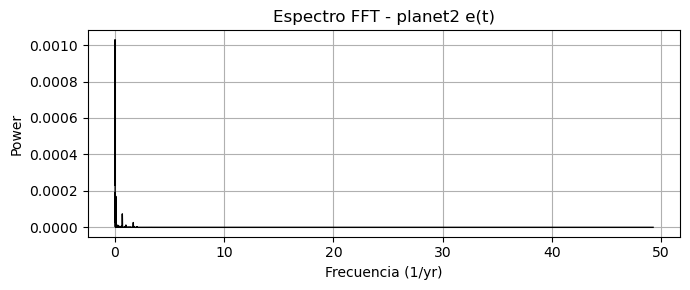

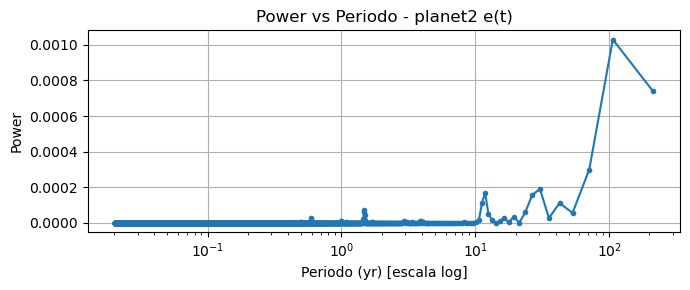

Top 6 picos para planet2 ϖ(t):
  f = 9.379810e-03 1/yr  =>  P = 1.066120e+02 yr  = 38940.021 d   power=4.883e+03
  f = 4.689905e-03 1/yr  =>  P = 2.132239e+02 yr  = 77880.042 d   power=4.671e+03
  f = 0.000000e+00 1/yr  =>  P = inf yr  = inf d   power=1.748e+03
  f = 1.875962e-02 1/yr  =>  P = 5.330598e+01 yr  = 19470.011 d   power=1.117e+03
  f = 1.406972e-02 1/yr  =>  P = 7.107464e+01 yr  = 25960.014 d   power=4.055e+02
  f = 2.344953e-02 1/yr  =>  P = 4.264479e+01 yr  = 15576.008 d   power=1.251e+02


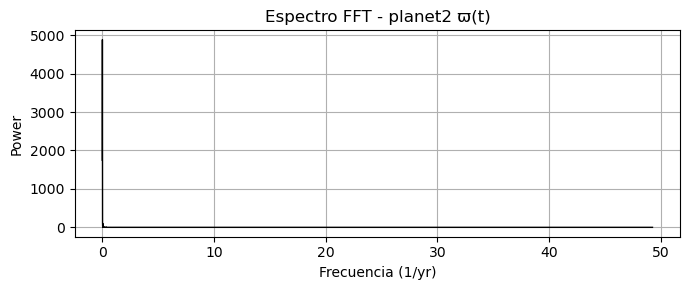

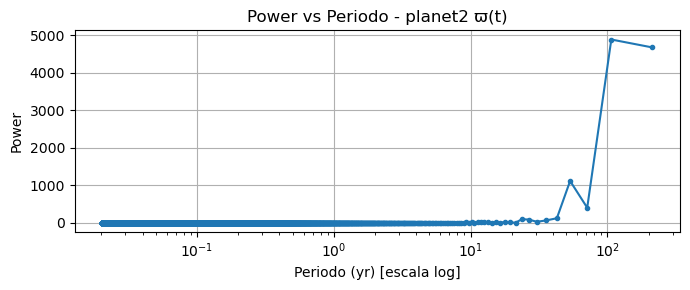

Top 6 picos para planet1 a(t):
  f = 0.000000e+00 1/yr  =>  P = inf yr  = inf d   power=4.008e-07
  f = 4.689905e-03 1/yr  =>  P = 2.132239e+02 yr  = 77880.042 d   power=2.777e-07
  f = 1.406972e-02 1/yr  =>  P = 7.107464e+01 yr  = 25960.014 d   power=1.994e-08
  f = 9.379810e-03 1/yr  =>  P = 1.066120e+02 yr  = 38940.021 d   power=1.667e-08
  f = 3.282934e-02 1/yr  =>  P = 3.046056e+01 yr  = 11125.720 d   power=9.557e-09
  f = 2.344953e-02 1/yr  =>  P = 4.264479e+01 yr  = 15576.008 d   power=7.119e-09


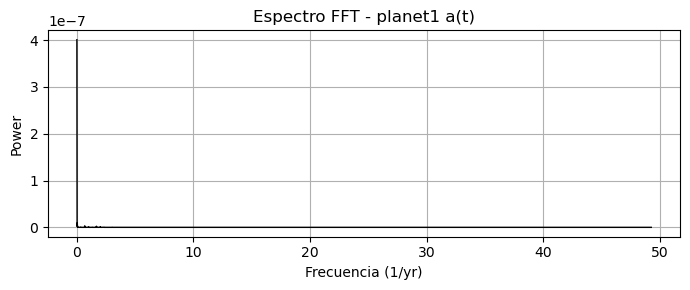

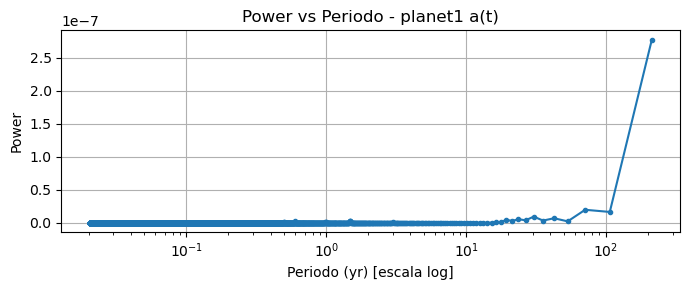

(array([0.00000000e+00, 4.68990501e-03, 9.37981003e-03, ...,
        4.92533824e+01, 4.92580724e+01, 4.92627623e+01], shape=(10505,)),
 array([4.00823523e-07, 2.77676548e-07, 1.66698817e-08, ...,
        1.31337153e-22, 7.48838674e-23, 3.15675622e-22], shape=(10505,)),
 array([0, 1, 3, 2, 7, 5]))

In [27]:
# ...existing code...
import numpy as np
import matplotlib.pyplot as plt

def fft_characteristic(t, y, dt=None, n_peaks=5, is_angle_deg=False, title=""):
    """
    Calcula FFT de y(t). t en años, dt en años (si None usa median_dt(t)).
    is_angle_deg=True -> unwrap grados antes de FFT.
    Devuelve freqs (1/yr), power, indices de picos y muestra gráficos.
    """
    if dt is None:
        dt = np.median(np.diff(np.sort(t)))
    # crear malla uniforme que cubra el rango de datos
    t0, t1 = np.min(t), np.max(t)
    N = max(4, int(np.floor((t1 - t0) / dt)) + 1)
    t_uv = t0 + np.arange(N) * dt
    # preparar y: unwrap si es ángulo en grados
    if is_angle_deg:
        y_cont = np.rad2deg(np.unwrap(np.deg2rad(y)))
    else:
        y_cont = y.copy()
    # interpolar a la malla uniforme
    y_uv = np.interp(t_uv, t, y_cont)
    # remover tendencia media
    y_uv = y_uv - np.mean(y_uv)
    # ventana para reducir fugas
    win = np.hanning(len(y_uv))
    y_win = y_uv * win
    # FFT real
    Y = np.fft.rfft(y_win)
    freqs = np.fft.rfftfreq(len(y_uv), dt)   # ciclos por año
    power = (np.abs(Y)**2) / len(y_uv)**2
    # buscar picos más relevantes por potencia
    idx_sorted = np.argsort(power)[::-1]
    peaks = idx_sorted[:n_peaks]
    # informar picos con sus periodos
    print(f"Top {n_peaks} picos para {title}:")
    for k in peaks:
        f = freqs[k]
        if f == 0:
            per_yr = np.inf
            per_days = np.inf
        else:
            per_yr = 1.0 / f
            per_days = per_yr * 365.25
        print(f"  f = {f:.6e} 1/yr  =>  P = {per_yr:.6e} yr  = {per_days:.3f} d   power={power[k]:.3e}")
    # graficos
    plt.figure(figsize=(7,3))
    plt.plot(freqs, power, '-k', lw=1)
    plt.xlabel("Frecuencia (1/yr)")
    plt.ylabel("Power")
    plt.title(f"Espectro FFT - {title}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # espectro en periodo (ordenar por periodo)
    nonzero = freqs > 0
    per = np.zeros_like(freqs)
    per[nonzero] = 1.0 / freqs[nonzero]
    per[~nonzero] = np.inf
    order = np.argsort(per)
    plt.figure(figsize=(7,3))
    plt.plot(per[order], power[order], '.-')
    plt.xscale('log')
    plt.xlabel("Periodo (yr) [escala log]")
    plt.ylabel("Power")
    plt.title(f"Power vs Periodo - {title}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return freqs, power, peaks

# Ejemplos: usar series cargadas previamente t1,a1,e1,varpi1,t2,...
# Asegúrate de que dt_out_yrs está definido (calculado antes como P_inner/100).
# Si no, pasa dt=None para usar el muestreo mediano de la serie.
# FFT de excentricidad (planeta interior)
fft_characteristic(t2, e2, dt=dt_out_yrs, n_peaks=6, is_angle_deg=False, title="planet2 e(t)")

# FFT de longitud del pericentro (planeta interior) -- usar unwrap
fft_characteristic(t2, varpi2, dt=dt_out_yrs, n_peaks=6, is_angle_deg=True, title="planet2 ϖ(t)")

# FFT del semieje mayor (planeta exterior)
fft_characteristic(t1, a1, dt=dt_out_yrs, n_peaks=6, is_angle_deg=False, title="planet1 a(t)")
# ...existing code...